In [19]:
import functools
import numpy as np
import qiskit as qk
import qiskit.providers.fake_provider as qk_fp
import qiskit_dynamics as qk_d

In [6]:
import sys
sys.path.append("../")
from pulse_simulator.compiler import RobustScheduler
import pulse_simulator as ps

In [7]:
# Set the parameters globally for the model
N = 4  # number of spins
hz = 1.0 * 2 * np.pi  # magnetic field along z
Jx = 1.0 * 2 * np.pi  # Coupling along x
Δt = 0.05  # time step for integration
tlist = np.arange(50) * Δt  # time values

# Global backend
backend = qk_fp.FakeManila()

In [11]:
def create_initial_state(qr, cr):
    """
    Creates the initial state for the experiment.
    Here we would like to prepare the |+>|+>|+>|+> state.
    """
    circ = qk.QuantumCircuit(qr, cr)
    [circ.h(qr[i]) for i in range(qr.size)]
    return circ


def rxx(circ, θx, q1, q2):
    """
    Implements the exp(-i theta/2 sx_1 sx_2) gate.
    """
    circ.cx(q1, q2)
    circ.rx(θx, q1)
    circ.cx(q1, q2)
    return circ


def first_order_Trotter_unitary(circ, Δt, barrier=False):
    """
    Applies a Unitary for a single time step U(Δt) using first-order trotter expansion to the input quantum circuit.
    input : circ is a quantum circuit
    output : circ-U(Δt)-
    """
    # Layer A: coupling XX between n and n+1
    # Induce parallel CR gates
    if barrier:
        circ.barrier()
    for p in range(0, circ.num_qubits - 1, 2):
        circ = rxx(circ, Jx * Δt, circ.qubits[p], circ.qubits[p + 1])
    if barrier:
        circ.barrier()
    for p in range(1, circ.num_qubits - 1, 2):
        circ = rxx(circ, Jx * Δt, circ.qubits[p], circ.qubits[p + 1])

    #  Alt., a naive loop will apply XX rotations sequentially, failing to stack.
    # for p in range(0, circ.num_qubits - 1):
    #     circ = rxx(circ, Jx * Δt, circ.qubits[p], circ.qubits[p + 1])

    # Layer B: on-site Z
    for p in range(circ.num_qubits):
        circ.rz(hz * Δt, circ.qubits[p])

    return circ


def second_order_Trotter_unitary(circ, Δt):
    """
    Applies a Unitary for a single time step U(Δt) using second-order trotter expansion to the input quantum circuit.
    input : circ is a quantum circuit
    output : circ-U(Δt)-
    """
    # Layer 2: on-site Z (half)
    for p in range(circ.num_qubits):
        circ.rz(hz * Δt / 2, circ.qubits[p])

    # Layer 1: coupling XX between n and n+1
    # Induce parallel structure (and symmetry)
    for p in range(1, circ.num_qubits - 1, 2):
        circ = rxx(circ, Jx * Δt / 2, circ.qubits[p], circ.qubits[p + 1])
    # NOTE: Add barriers to separate the parallel section
    circ.barrier()
    for p in range(0, circ.num_qubits - 1, 2):
        circ = rxx(circ, Jx * Δt, circ.qubits[p], circ.qubits[p + 1])
    circ.barrier()
    for p in range(1, circ.num_qubits - 1, 2):
        circ = rxx(circ, Jx * Δt / 2, circ.qubits[p], circ.qubits[p + 1])

    # Layer 2: on-site Z (half)
    for p in range(circ.num_qubits):
        circ.rz(hz * Δt / 2, circ.qubits[p])
    return circ

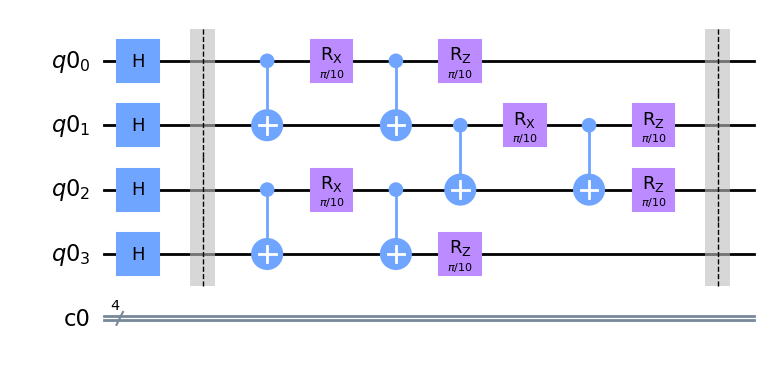

In [12]:
qr = qk.QuantumRegister(N)
cr = qk.ClassicalRegister(N)
circ = create_initial_state(qr, cr)
circ.barrier()
circ = first_order_Trotter_unitary(circ, Δt)
circ.barrier()
circ.draw("mpl", style="clifford")

In [13]:
basis_gates = ["rz", "x", "sx", "rzx", "id"]
scheduler = RobustScheduler(
    basis_gates=basis_gates, reattach=False, attach_final_virtual=False
)
circ = qk.transpiler.passes.RemoveBarriers()(circ)
scheduled_dag = scheduler.run(circ, return_dag=True)

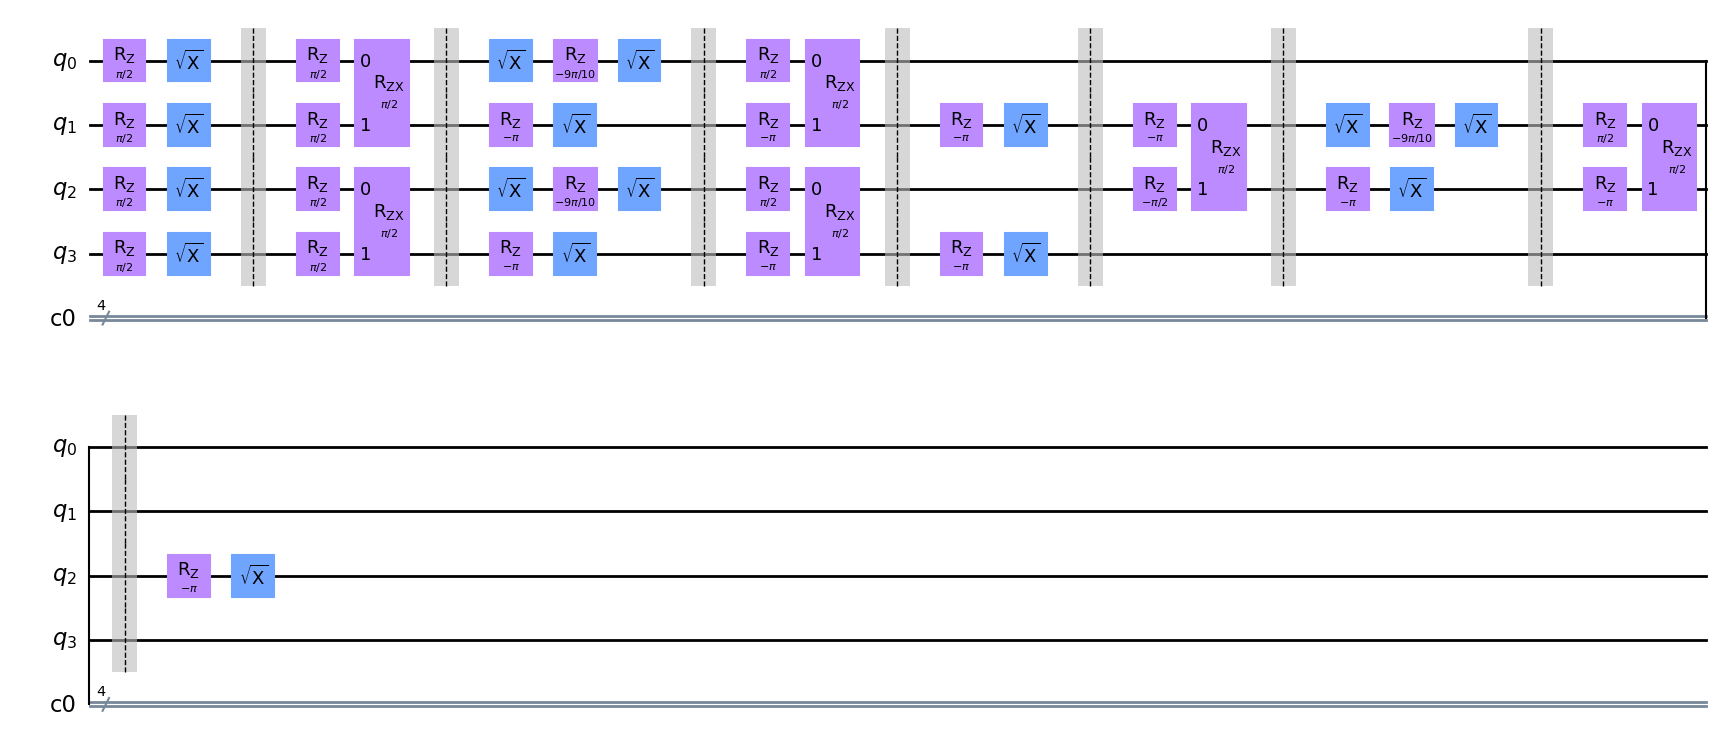

In [15]:
# the final output with virtual zs should look something like
RobustScheduler(basis_gates=basis_gates, reattach=True, attach_final_virtual=False).run(circ).draw("mpl", style="clifford")

In [8]:
one_qubit_coloring = {qubit: "red" if qubit % 2 == 0 else "blue" for qubit in range(N)}
one_qubit_coloring

{0: 'red', 1: 'blue', 2: 'red', 3: 'blue'}

In [8]:
flag = True
two_qubit_coloring = {}
for qubit in range(N - 1):
    if qubit % 2 == 0:
        flag = not flag
    two_qubit_coloring[tuple({qubit, qubit + 1})] = "blue" if flag else "red"
two_qubit_coloring

{(0, 1): 'red', (1, 2): 'red', (2, 3): 'blue'}

Here, that (0, 1) and (1, 2) have the same color is not a problem, since two-qubit operations in these pairs of qubits can never be in parallel.

In [10]:
subdags = [layer["graph"] for layer in scheduled_dag.layers()]

In [11]:
from qiskit import QuantumRegister
from qiskit.circuit import Qubit


def virtual_str_to_dict(virtual: str) -> dict[int, str]:
    processed = virtual.split("|")
    params = eval(processed[1])
    qargs = eval(processed[2])
    return {qargs._index: params[0]}

In [12]:
moments = []

for subdag in subdags:
    gates = subdag.op_nodes(include_directives=True)

    gates_dict = {}
    virtual_zs = {}
    for gate in gates:
        if gate.op.name == "barrier":
            break

        qargs = gate.qargs

        if len(qargs) == 1:
            qubit = gate.qargs[0]
            index = scheduled_dag.find_bit(qubit).index
            color = one_qubit_coloring[index]
            gates_dict[index] = f"{gate.op.name}_{color}"

            if virtual := gate.op.label:
                virtual_zs.update(virtual_str_to_dict(virtual))

        elif len(qargs) == 2:
            q0, q1 = gate.qargs[0], gate.qargs[1]
            i0 = scheduled_dag.find_bit(q0).index
            i1 = scheduled_dag.find_bit(q1).index

            # check for linear connectivity
            assert i0 == i1 + 1 or i1 == i0 + 1
            color = two_qubit_coloring[tuple({i0, i1})]
            gates_dict[(i0, i1)] = f"{gate.op.name}_{color}"

            if virtuals := gate.op.label:
                for virtual in virtuals.split("&"):
                    virtual_zs.update(virtual_str_to_dict(virtual))

    if gates_dict:
        moments.append((gates_dict, virtual_zs))

if final_virtuals := scheduler._final_virtuals:
    virtual_zs = {}
    for qubit in final_virtuals:
        virtual_zs.update(virtual_str_to_dict(final_virtuals[qubit]))
    moments.append(({}, virtual_zs))

In [13]:
moments

[({0: 'sx_red', 1: 'sx_blue', 2: 'sx_red', 3: 'sx_blue'},
  {0: 1.5707963267948966,
   1: 1.5707963267948966,
   2: 1.5707963267948966,
   3: 1.5707963267948966}),
 ({(0, 1): 'rzx_red', (2, 3): 'rzx_blue'},
  {0: 1.5707963267948966,
   1: 1.5707963267948966,
   2: 1.5707963267948966,
   3: 1.5707963267948966}),
 ({0: 'sx_red', 1: 'sx_blue', 2: 'sx_red', 3: 'sx_blue'},
  {1: -3.141592653589793, 3: -3.141592653589793}),
 ({0: 'sx_red', 2: 'sx_red'}, {0: -2.827433388230814, 2: -2.827433388230814}),
 ({(0, 1): 'rzx_red', (2, 3): 'rzx_blue'},
  {0: 1.5707963267948966,
   1: -3.141592653589793,
   2: 1.5707963267948966,
   3: -3.141592653589793}),
 ({1: 'sx_blue', 3: 'sx_blue'},
  {1: -3.141592653589793, 3: -3.141592653589793}),
 ({(1, 2): 'rzx_red'}, {1: -3.141592653589793, 2: -1.5707963267948966}),
 ({1: 'sx_blue', 2: 'sx_red'}, {2: -3.141592653589793}),
 ({1: 'sx_blue'}, {1: -2.827433388230814}),
 ({(1, 2): 'rzx_red'}, {1: 1.5707963267948966, 2: -3.141592653589793}),
 ({2: 'sx_red'}, {2: 

### Simulating

In [21]:
def gaussian(x, mu=0, sigma=1):
    return np.exp(-(x - mu)**2 / 2 / sigma**2)

def lifted_gaussian(x, mu, sigma, x0=-1):
    g = functools.partial(gaussian, mu=mu, sigma=sigma)
    return (g(x) - g(x0)) / (1 - g(x0))

def truncated_gaussian(x, mu=0, sigma=1):
    g = functools.partial(gaussian, mu=mu, sigma=sigma)
    return g(x) - g(0)

def gaussian_envelope(dt, duration, angle=np.pi):
    """ Define gaussian envelope function to accumulate the angle.

    Returns:
        Qiskit pulse implementing angle.
    """
    steps = int(duration / dt)

    # Arbitrary shape
    # NOTE: Qiskit doesn't like pulse amplitudes > 1. Widen to avoid this.
    sigma = steps / 4
    mu = steps / 2

    # Normalize
    x = np.linspace(0, steps, endpoint=True)
    area = np.trapz(lifted_gaussian(x, mu, sigma), x)
    amplitude = angle / area / dt

    # Adjust the amplitude to achieve the angle
    return qk.pulse.Gaussian(steps, amplitude, sigma)

def zero_envelope(dt, duration):
    steps = int(duration / dt)
    return qk.pulse.Constant(steps, 0.0)

In [29]:
backend = qk_fp.FakeManila()

# Initialize device
# =====
# Undo units
units = 1e9
GHz = 1/units
ns = units

dt = backend.configuration().dt * ns  
duration = 220 * dt  # ns

registers = [0, 1, 2, 3]  # TODO: Active registers

# Variables
# NOTE: If the Rabi rates are different, you have to calibrate!
config_vars = ps.backend_simulation_vars(backend, rabi=False, units=units)

# Carrier frequencies of each control line
carriers = ps.backend_carriers(backend, config_vars)

In [40]:
gate_lookup = {
    "sx_red": gaussian_envelope(dt, duration, angle=np.pi/4),
    "sx_blue": gaussian_envelope(dt, duration, angle=np.pi/4),
    "x_red": gaussian_envelope(dt, duration, angle=np.pi/2),
    "x_blue": gaussian_envelope(dt, duration, angle=np.pi/2),
}

gates = moments[0][0]
virtual_zs = moments[0][1]

# Design pulse schedule
# =====
with qk.pulse.build(name="Current moment") as pulse_moment:
    for i, gate in gates.items():
        channel = qk.pulse.DriveChannel(i)
        # NOTE:     Shift phase will adjust the carry and future gates. 
        #           Restricted to the current moment, it should be the same as 
        #           a zero time R_Z gate. This doesn't seem to work if you
        #           aren't using carriers, so we just toss the gates in.
        qk.pulse.shift_phase(virtual_zs[i], channel)
        qk.pulse.play(gate_lookup[gate], channel)

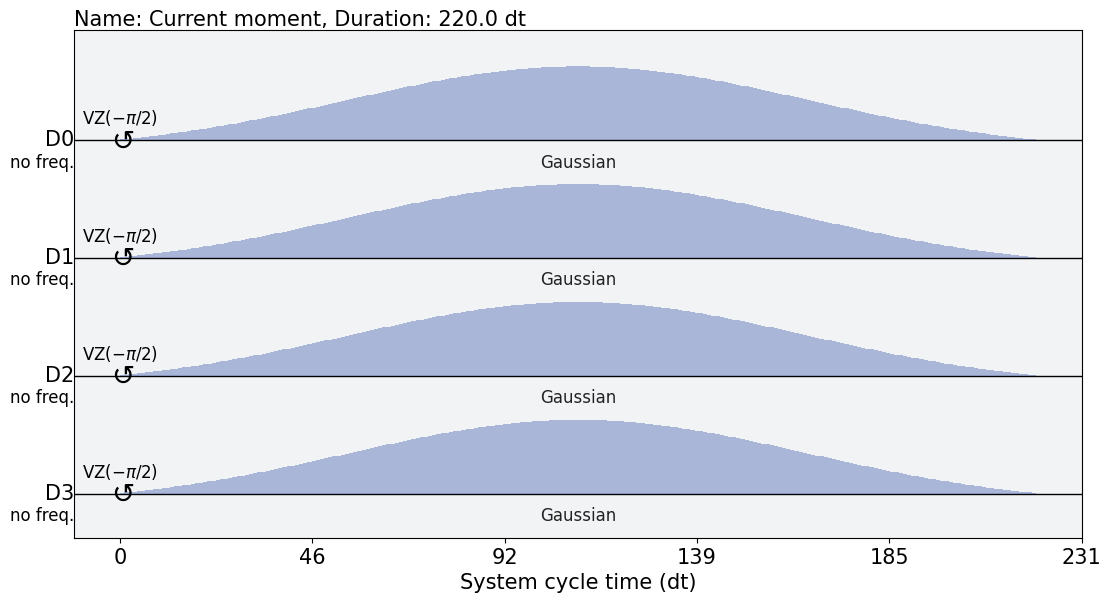

In [42]:
pulse_moment.draw()

In [43]:
# The two qubit CR interaction
control_gate_lookup = {
    "rzx_red": gaussian_envelope(dt, duration, angle=np.pi/2),
    "rzx_blue": gaussian_envelope(dt, duration, angle=np.pi/2),
}
# The one qubit target drive
target_gate_lookup = {
    "rzx_red": zero_envelope(dt, duration),
    "rzx_blue": zero_envelope(dt, duration),
}

gates = moments[1][0]
virtual_zs = moments[1][1]

# Design pulse schedule
# =====
with qk.pulse.build(name="Two moment") as two_pulse_moment:
    for (c, t), gate in gates.items():
        control_channel = ps.get_control_channel(c, t, backend)
        target_channel = ps.get_drive_channel(t, backend)

        # # Replace Virtual Z => Zero time Rz gate
        # for i in virtual_zs.items():
        #     if i == c:
        #         qk.pulse.shift_phase(virtual_zs[i], control_channel)
        #     elif i == t:
        #         qk.pulse.shift_phase(virtual_zs[i], target_channel)

        # Pulses must work together
        qk.pulse.play(control_gate_lookup[gate], control_channel)
        qk.pulse.play(target_gate_lookup[gate], target_channel)

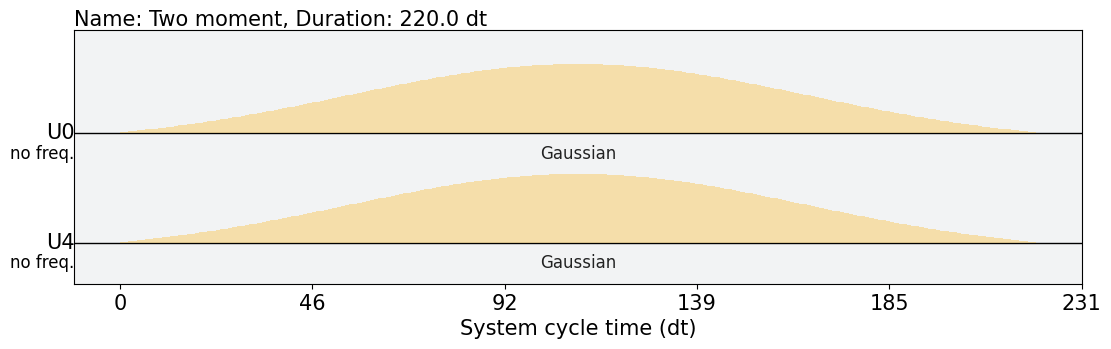

In [44]:
two_pulse_moment.draw()

Not sure if the above is right.